In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
!pip install -q efficientnet
import math, re, os
import tensorflow as tf
import numpy as np
import efficientnet.tfkeras as efn
from matplotlib import pyplot as plt
from kaggle_datasets import KaggleDatasets
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

Tensorflow version 2.1.0


In [3]:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


## Loading Dataset

In [4]:
def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

In [5]:
GCS_DS_PATH = KaggleDatasets().get_gcs_path('flower-classification-with-tpus')

IMAGE_SIZE = [224, 224] # at this size, a GPU will run out of memory. Use the TPU
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

GCS_PATH_SELECT = { # available image sizes
    192: GCS_DS_PATH + '/tfrecords-jpeg-192x192',
    224: GCS_DS_PATH + '/tfrecords-jpeg-224x224',
    331: GCS_DS_PATH + '/tfrecords-jpeg-331x331',
    512: GCS_DS_PATH + '/tfrecords-jpeg-512x512'
}
GCS_PATH = GCS_PATH_SELECT[IMAGE_SIZE[0]]

TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec') # predictions on this dataset should be submitted for the competition
count_data_items(TRAINING_FILENAMES)

12753

In [6]:
GCS_DS_PATH

'gs://kds-b2e6cdbc4af76dcf0363776c09c12fe46872cab211d1de9f60ec7aec'

In [7]:
GCS_DS_PATH = KaggleDatasets().get_gcs_path('oxford-flowers-tfrecords')
#IMAGE_SIZE = [512, 512] # at this size, a GPU will run out of memory. Use the TPU
#BATCH_SIZE = 32 * strategy.num_replicas_in_sync

#GCS_PATH_SELECT = { # available image sizes
#    192: GCS_DS_PATH + '/oxford/tfrecords-jpeg-192x192',
#    224: GCS_DS_PATH + '/oxford/tfrecords-jpeg-224x224',
#    331: GCS_DS_PATH + '/oxford/tfrecords-jpeg-331x331',
 #   512: GCS_DS_PATH + '/oxford/tfrecords-jpeg-512x512'
#}
#GCS_PATH = GCS_PATH_SELECT[IMAGE_SIZE[0]]

#TRAINING_FILENAMES += tf.io.gfile.glob(GCS_PATH + '*.tfrec')
# VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
# TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec')
#count_data_items(TRAINING_FILENAMES)

In [8]:
GCS_DS_PATH

'gs://kds-34352f94741b22f5361e3a37950db047f833ed64476f332409f43832'

In [9]:
CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']                                                                                                                                               # 100 - 102

In [10]:
# using validation set for training to inch out last marginal performance improvement
VALIDATION = True
if not VALIDATION:
    TRAINING_FILENAMES = TRAINING_FILENAMES+VALIDATION_FILENAMES

In [11]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

def data_augment(image, label):
    # data augmentation. Thanks to the dataset.prefetch(AUTO) statement in the next function (below),
    # this happens essentially for free on TPU. Data pipeline code is executed on the "CPU" part
    # of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_flip_left_right(image)
    #image = tf.image.random_saturation(image, 0, 2)
    return image, label   

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

Dataset: 12753 training images, 3712 validation images, 7382 unlabeled test images


In [12]:
STEPS_PER_EPOCH

99

In [13]:
# data dump
print("Training data shapes:")
for image, label in get_training_dataset().take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Training data label examples:", label.numpy())
print("Validation data shapes:")
for image, label in get_validation_dataset().take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Validation data label examples:", label.numpy())
print("Test data shapes:")
for image, idnum in get_test_dataset().take(3):
    print(image.numpy().shape, idnum.numpy().shape)
print("Test data IDs:", idnum.numpy().astype('U')) # U=unicode string

Training data shapes:
(128, 224, 224, 3) (128,)
(128, 224, 224, 3) (128,)
(128, 224, 224, 3) (128,)
Training data label examples: [ 68  77  28  13  55  87 103  49  42  49  71  91 102  67  49   0  56  47
  14  68  87  18  68  96  13  95  77  67  73  49  41  48 102  76  87  74
   4  40  48   0  77  72  48  40  24   8   9  45  81  56  67 103  67  25
 103  67  75  59  47  40 103  91  49   4  38  60  91  17  71   4   2  29
  48  12  98  50  49  73  75  47  53  10  40 103  69  71  48  43  49  88
  96   4  73  76  28  53  39   9  83  49  16   4  43  53  12  49   4   4
  57  49  86  29  67 102  82   0  14  73  91  67  19 103  75  73  71  91
  49  57]
Validation data shapes:
(128, 224, 224, 3) (128,)
(128, 224, 224, 3) (128,)
(128, 224, 224, 3) (128,)
Validation data label examples: [102  67   5  67  50  72  67  67  93  80  53  87  95  46   4 103   3  89
  35  94  93  49 103  56  67  35  79  87  55  87  75   7 102  46   4  50
   4  46  72  12  82  28  83  53   4  72  50 103 100  62  48 102  54 

## Vizualization

In [14]:
# numpy and matplotlib defaults
np.set_printoptions(threshold=15, linewidth=80)

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case, these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)
    
def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

def display_confusion_matrix(cmat, score, precision, recall):
    plt.figure(figsize=(15,15))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(CLASSES)))
    ax.set_yticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    titlestring = ""
    if score is not None:
        titlestring += 'f1 = {:.3f} '.format(score)
    if precision is not None:
        titlestring += '\nprecision = {:.3f} '.format(precision)
    if recall is not None:
        titlestring += '\nrecall = {:.3f} '.format(recall)
    if len(titlestring) > 0:
        ax.text(101, 1, titlestring, fontdict={'fontsize': 18, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
    plt.show()
    
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

In [15]:
# Peek at training data
training_dataset = get_training_dataset()
training_dataset = training_dataset.unbatch().batch(20)
train_batch = iter(training_dataset)

In [16]:
# run this cell again for next set of images
#display_batch_of_images(next(train_batch))

In [17]:
# peer at test data
test_dataset = get_test_dataset()
test_dataset = test_dataset.unbatch().batch(20)
test_batch = iter(test_dataset)

In [18]:
# run this cell again for next set of images
#display_batch_of_images(next(test_batch))

## LR Scheduler 

Learning rate schedule: 3.13e-05 to 0.0004 to 2.72e-05


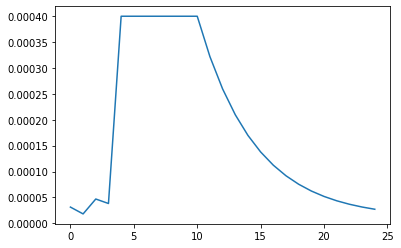

In [19]:
EPOCHS = 20
LR_START = 0.0001
LR_MAX = 0.00005 * strategy.num_replicas_in_sync
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 4
LR_SUSTAIN_EPOCHS = 6
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = np.random.random_sample() * LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)
es_callback = tf.keras.callbacks.EarlyStopping(min_delta=0, patience=10, verbose=1, mode='auto', restore_best_weights=True)

rng = [i for i in range(25 if EPOCHS<25 else EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

## Building Models

### DenseNET201

In [20]:

with strategy.scope():
    dn201 = tf.keras.applications.DenseNet201(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])
    dn201.trainable = True # Full Training
    
    model1 = tf.keras.Sequential([
        dn201,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
        
model1.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)
model1.summary()


74842112/74836368 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Model)          (None, 7, 7, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 104)               199784    
Total params: 18,521,768
Trainable params: 18,292,712
Non-trainable params: 229,056
_________________________________________________________________


### EfficientNET B7

In [21]:
with strategy.scope():
    enb7 = efn.EfficientNetB7(weights='noisy-student', include_top=False, input_shape=[*IMAGE_SIZE, 3])
    enb7.trainable = True # Full Training
    
    model2 = tf.keras.Sequential([
        enb7,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
        
model2.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False),
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)
model2.summary()

258072576/258068648 [==============================] - 3s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b7 (Model)      (None, 7, 7, 2560)        64097680  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2560)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 104)               266344    
Total params: 64,364,024
Trainable params: 64,053,304
Non-trainable params: 310,720
_________________________________________________________________


### InceptionResNetV2

In [22]:
with strategy.scope():
    Inet = tf.keras.applications.InceptionResNetV2(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])
    Inet.trainable = True # Full Training
    
    model3 = tf.keras.Sequential([
        Inet,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
        
model3.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)
model3.summary()


219062272/219055592 [==============================] - 4s 0us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 5, 5, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1536)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 104)               159848    
Total params: 54,496,584
Trainable params: 54,436,040
Non-trainable params: 60,544
_________________________________________________________________


## Training

In [23]:
history1 = model1.fit(
    get_training_dataset(), 
    steps_per_epoch=STEPS_PER_EPOCH, 
    epochs=EPOCHS, 
    validation_data= None if not VALIDATION else get_validation_dataset(), 
    callbacks = [lr_callback])    

Train for 99 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 1.9570599519062104e-05.
Epoch 1/20
99/99 [==============================] - 245s 2s/step - loss: 3.7652 - sparse_categorical_accuracy: 0.2342 - val_loss: 2.7062 - val_sparse_categorical_accuracy: 0.4116

Epoch 00002: LearningRateScheduler reducing learning rate to 3.587587470103295e-05.
Epoch 2/20
99/99 [==============================] - 25s 250ms/step - loss: 1.8846 - sparse_categorical_accuracy: 0.6212 - val_loss: 1.2686 - val_sparse_categorical_accuracy: 0.7155

Epoch 00003: LearningRateScheduler reducing learning rate to 9.999255069842836e-05.
Epoch 3/20
99/99 [==============================] - 25s 253ms/step - loss: 0.8671 - sparse_categorical_accuracy: 0.8270 - val_loss: 0.5761 - val_sparse_categorical_accuracy: 0.8642

Epoch 00004: LearningRateScheduler reducing learning rate to 8.270054302874043e-05.
Epoch 4/20
99/99 [==============================] - 25s 249ms/step - loss: 0.4084 - sparse_categori

In [24]:
history2 = model2.fit(
    get_training_dataset(), 
    steps_per_epoch=128, 
    epochs=EPOCHS, 
    validation_data= None if not VALIDATION else get_validation_dataset(), 
    callbacks = [lr_callback] )   

Train for 128 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 3.93398869453525e-05.
Epoch 1/20
128/128 [==============================] - 296s 2s/step - loss: 4.3837 - sparse_categorical_accuracy: 0.1167 - val_loss: 4.1657 - val_sparse_categorical_accuracy: 0.1724

Epoch 00002: LearningRateScheduler reducing learning rate to 7.412026839290775e-06.
Epoch 2/20
128/128 [==============================] - 40s 315ms/step - loss: 3.9221 - sparse_categorical_accuracy: 0.2041 - val_loss: 3.9889 - val_sparse_categorical_accuracy: 0.2349

Epoch 00003: LearningRateScheduler reducing learning rate to 7.072890837033161e-05.
Epoch 3/20
128/128 [==============================] - 40s 314ms/step - loss: 3.1649 - sparse_categorical_accuracy: 0.3164 - val_loss: 2.4652 - val_sparse_categorical_accuracy: 0.4914

Epoch 00004: LearningRateScheduler reducing learning rate to 6.790684268464884e-05.
Epoch 4/20
128/128 [==============================] - 40s 315ms/step - loss: 2.0860 - sparse_c

In [25]:
history3 = model3.fit(
    get_training_dataset(), 
    steps_per_epoch=STEPS_PER_EPOCH, 
    epochs=EPOCHS, 
    validation_data= None if not VALIDATION else get_validation_dataset(), 
    callbacks = [lr_callback] )   

Train for 99 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 5.204928960779404e-05.
Epoch 1/20
99/99 [==============================] - 213s 2s/step - loss: 2.9047 - sparse_categorical_accuracy: 0.3977 - val_loss: 1.6882 - val_sparse_categorical_accuracy: 0.5862

Epoch 00002: LearningRateScheduler reducing learning rate to 2.214017242120474e-05.
Epoch 2/20
99/99 [==============================] - 23s 231ms/step - loss: 1.3446 - sparse_categorical_accuracy: 0.7058 - val_loss: 1.1353 - val_sparse_categorical_accuracy: 0.7069

Epoch 00003: LearningRateScheduler reducing learning rate to 9.449670543579059e-05.
Epoch 3/20
99/99 [==============================] - 22s 227ms/step - loss: 0.7968 - sparse_categorical_accuracy: 0.8131 - val_loss: 0.8547 - val_sparse_categorical_accuracy: 0.8125

Epoch 00004: LearningRateScheduler reducing learning rate to 9.071461502076397e-05.
Epoch 4/20
99/99 [==============================] - 23s 229ms/step - loss: 0.3676 - sparse_categoric

### Training_curves

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:95: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


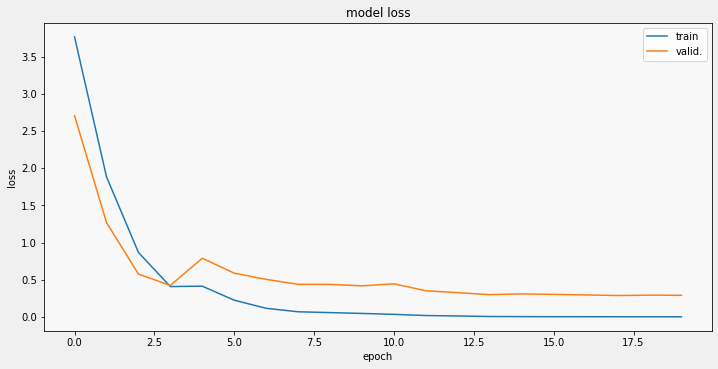

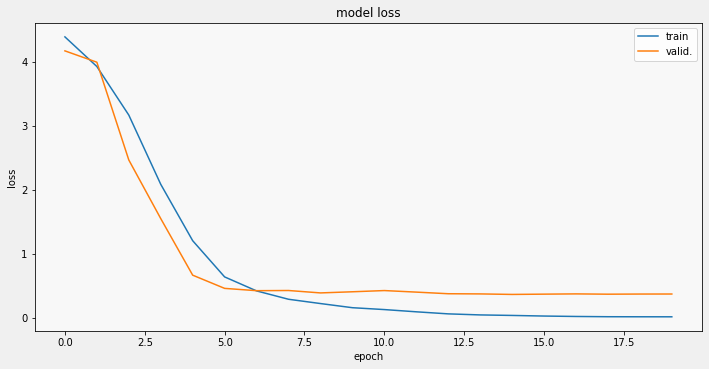

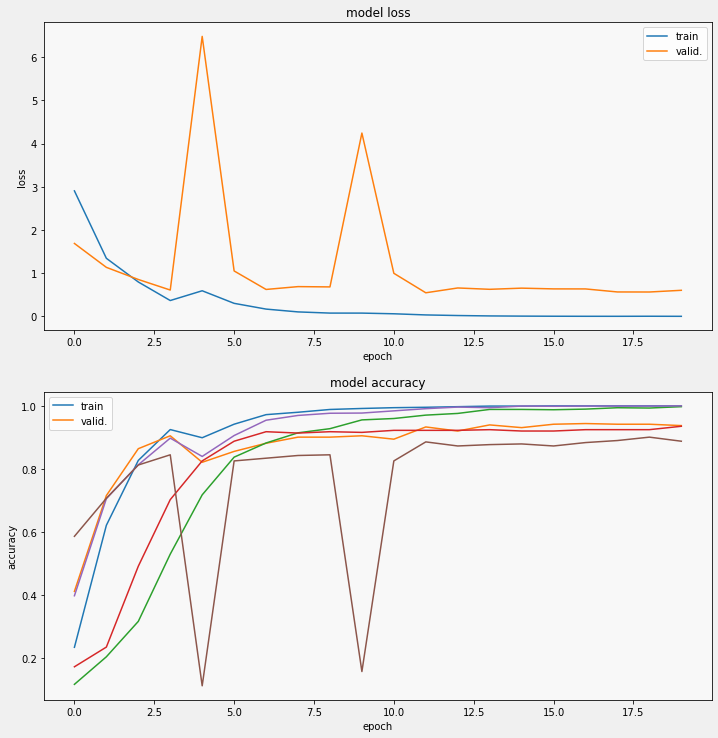

In [26]:
if VALIDATION:
    display_training_curves(history1.history['loss'], history1.history['val_loss'], 'loss', 211)
    display_training_curves(history2.history['loss'], history2.history['val_loss'], 'loss', 211)
    display_training_curves(history3.history['loss'], history3.history['val_loss'], 'loss', 211)

    display_training_curves(history1.history['sparse_categorical_accuracy'], history1.history['val_sparse_categorical_accuracy'], 'accuracy', 212)
    display_training_curves(history2.history['sparse_categorical_accuracy'], history2.history['val_sparse_categorical_accuracy'], 'accuracy', 212)
    display_training_curves(history3.history['sparse_categorical_accuracy'], history3.history['val_sparse_categorical_accuracy'], 'accuracy', 212)
    

## Finding best alpha
Our final model is just mix of two presented above. Note that using validation data as training will fit your model with accuracy equal 1.0. Thus formula presented below of linear combination of models will work only with validation data:

prob = alpha prob(model) + (1 - alpha) prob(model2)

## Model-1 & Model-2

Correct   labels:  (3712,) [ 50  13  74 ... 102  48  67]
Predicted labels:  (3712,) [ 50  13  74 ... 102  48  67]
0.56


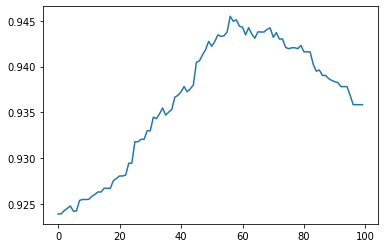

In [27]:
if VALIDATION:
    cmdataset = get_validation_dataset(ordered=True) # since we are splitting the dataset and iterating separately on images and labels, order matters.
    images_ds = cmdataset.map(lambda image, label: image)
    labels_ds = cmdataset.map(lambda image, label: label).unbatch()
    cm_correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy() # get everything as one batch
    m = model1.predict(images_ds)
    m2 = model2.predict(images_ds)
    scores = []
    for alpha in np.linspace(0,1,100):
        cm_probabilities = alpha*m+(1-alpha)*m2
        cm_predictions = np.argmax(cm_probabilities, axis=-1)
        scores.append(f1_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro'))
        
    print("Correct   labels: ", cm_correct_labels.shape, cm_correct_labels)
    print("Predicted labels: ", cm_predictions.shape, cm_predictions)
    plt.plot(scores)
    best_alpha = np.argmax(scores)/100
    cm_probabilities = best_alpha*m+(1-best_alpha)*m2
    cm_predictions = np.argmax(cm_probabilities, axis=-1)
else:
    best_alpha = 0.44
    
print(best_alpha)

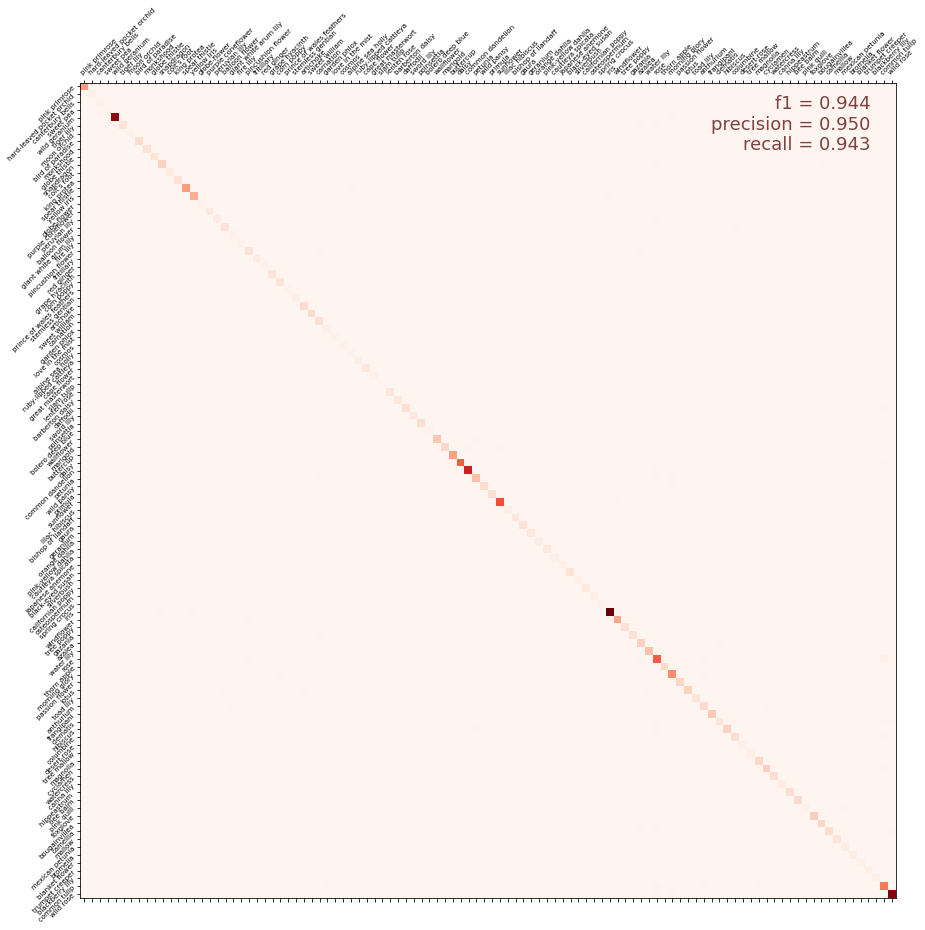

f1 score: 0.944, precision: 0.950, recall: 0.943


In [28]:
if VALIDATION: 
    cmat = confusion_matrix(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)))
    score = f1_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
    precision = precision_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
    recall = recall_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
    #cmat = (cmat.T / cmat.sum(axis=1)).T # normalized
    display_confusion_matrix(cmat, score, precision, recall)
    print('f1 score: {:.3f}, precision: {:.3f}, recall: {:.3f}'.format(score, precision, recall))

## Model2 & Model3

Correct   labels:  (3712,) [ 50  13  74 ... 102  48  67]
Predicted labels:  (3712,) [ 50  13  74 ... 102  48  67]
0.5


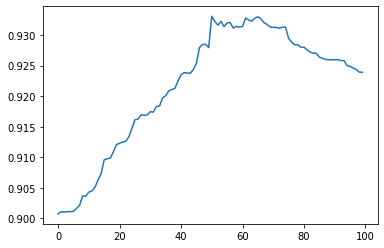

In [29]:
if VALIDATION:
    cmdataset = get_validation_dataset(ordered=True) # since we are splitting the dataset and iterating separately on images and labels, order matters.
    images_ds = cmdataset.map(lambda image, label: image)
    labels_ds = cmdataset.map(lambda image, label: label).unbatch()
    cm_correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy() # get everything as one batch
    m = model2.predict(images_ds)
    m2 = model3.predict(images_ds)
    scores = []
    for alpha in np.linspace(0,1,100):
        cm_probabilities = alpha*m+(1-alpha)*m2
        cm_predictions = np.argmax(cm_probabilities, axis=-1)
        scores.append(f1_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro'))
        
    print("Correct   labels: ", cm_correct_labels.shape, cm_correct_labels)
    print("Predicted labels: ", cm_predictions.shape, cm_predictions)
    plt.plot(scores)
    best_alpha = np.argmax(scores)/100
    cm_probabilities = best_alpha*m+(1-best_alpha)*m2
    cm_predictions = np.argmax(cm_probabilities, axis=-1)
else:
    best_alpha = 0.44
    
print(best_alpha)

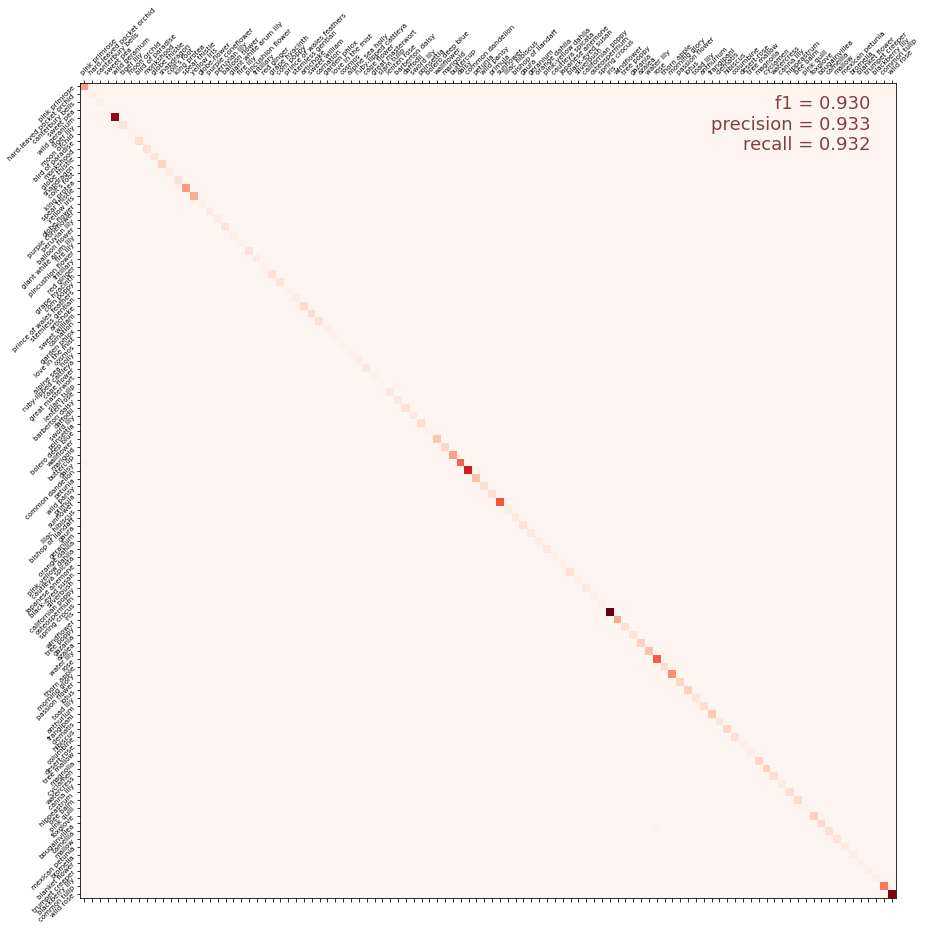

f1 score: 0.930, precision: 0.933, recall: 0.932


In [30]:
if VALIDATION: 
    cmat = confusion_matrix(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)))
    score = f1_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
    precision = precision_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
    recall = recall_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
    #cmat = (cmat.T / cmat.sum(axis=1)).T # normalized
    display_confusion_matrix(cmat, score, precision, recall)
    print('f1 score: {:.3f}, precision: {:.3f}, recall: {:.3f}'.format(score, precision, recall))

## Model1 & Model3

Correct   labels:  (3712,) [ 50  13  74 ... 102  48  67]
Predicted labels:  (3712,) [ 50  13  74 ... 102  48  67]
0.56


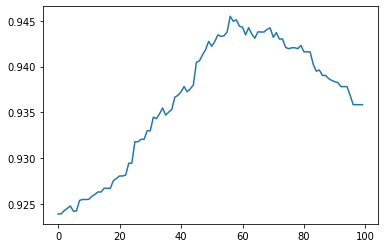

In [31]:
if VALIDATION:
    cmdataset = get_validation_dataset(ordered=True) # since we are splitting the dataset and iterating separately on images and labels, order matters.
    images_ds = cmdataset.map(lambda image, label: image)
    labels_ds = cmdataset.map(lambda image, label: label).unbatch()
    cm_correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy() # get everything as one batch
    m = model1.predict(images_ds)
    m2 = model2.predict(images_ds)
    scores = []
    for alpha in np.linspace(0,1,100):
        cm_probabilities = alpha*m+(1-alpha)*m2
        cm_predictions = np.argmax(cm_probabilities, axis=-1)
        scores.append(f1_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro'))
        
    print("Correct   labels: ", cm_correct_labels.shape, cm_correct_labels)
    print("Predicted labels: ", cm_predictions.shape, cm_predictions)
    plt.plot(scores)
    best_alpha = np.argmax(scores)/100
    cm_probabilities = best_alpha*m+(1-best_alpha)*m2
    cm_predictions = np.argmax(cm_probabilities, axis=-1)
else:
    best_alpha = 0.44
    
print(best_alpha)

### Confusion Matrix

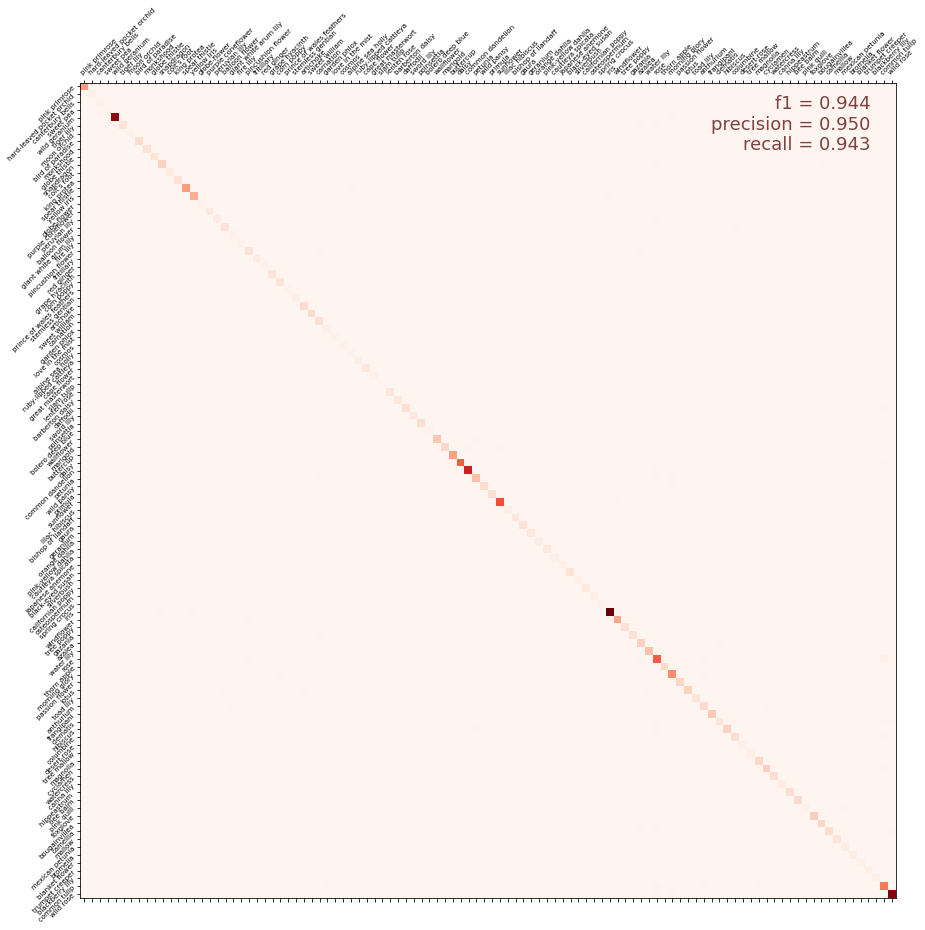

f1 score: 0.944, precision: 0.950, recall: 0.943


In [32]:
if VALIDATION: 
    cmat = confusion_matrix(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)))
    score = f1_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
    precision = precision_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
    recall = recall_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
    #cmat = (cmat.T / cmat.sum(axis=1)).T # normalized
    display_confusion_matrix(cmat, score, precision, recall)
    print('f1 score: {:.3f}, precision: {:.3f}, recall: {:.3f}'.format(score, precision, recall))

## Finding Best Alpha and Beta

best_alha: 0.5353535353535354 best_beta: 0.17171717171717174


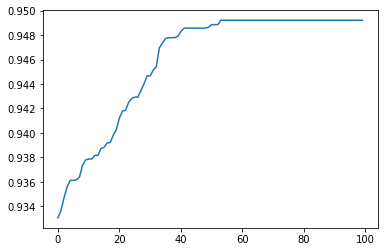

In [33]:
if VALIDATION: 
    cmdataset = get_validation_dataset(ordered=True) # since we are splitting the dataset and iterating separately on images and labels, order matters.
    images_ds = cmdataset.map(lambda image, label: image)
    labels_ds = cmdataset.map(lambda image, label: label).unbatch()
    cm_correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy() # get everything as one batch
    m = model1.predict(images_ds)
    m2 = model2.predict(images_ds)
    m3 = model3.predict(images_ds)
    scores = []
    best_score,best_alpha,best_beta=0,0,0
    for alpha in np.linspace(0,1,100):
        for beta in np.linspace(0,1,100):
            cm_probabilities = alpha*m+(beta)*m2+(1-alpha-beta)*m3
            cm_predictions = np.argmax(cm_probabilities, axis=-1)#花的种类
            score = f1_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
            #scores.append(score)
        
            #print("Correct   labels: ", cm_correct_labels.shape, cm_correct_labels)
            #print("Predicted labels: ", cm_predictions.shape, cm_predictions)
            #plt.plot(scores)
            if(score > best_score):
                best_alpha = alpha
                best_beta  = beta
                best_score = score
        scores.append(best_score)
    plt.plot(scores)
    print("best_alha:",best_alpha,"best_beta:",best_beta)
    cm_probabilities = best_alpha*m+best_beta*m2+(1-best_alpha)*m3
    cm_predictions = np.argmax(cm_probabilities, axis=-1)
else:
    best_alpha = 0.505
    best_beta = 0.30

In [34]:
print(best_alpha,best_beta)

0.5353535353535354 0.17171717171717174


### Confusion Matrix

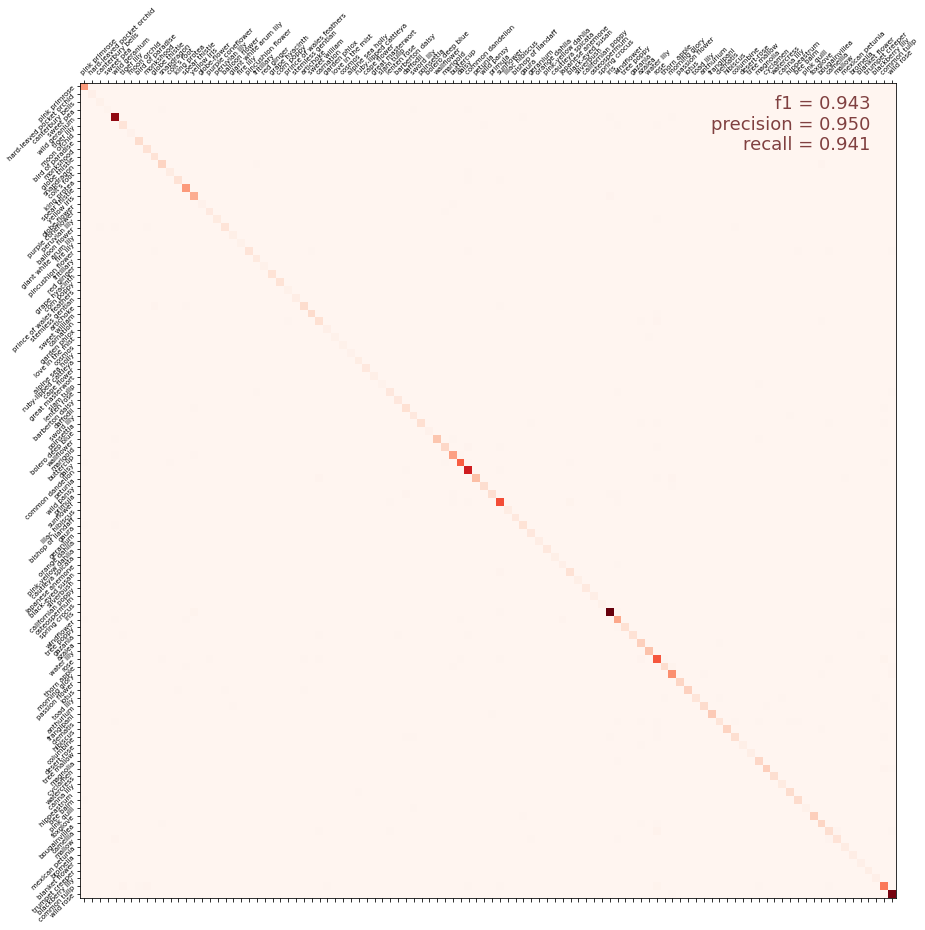

f1 score: 0.943, precision: 0.950, recall: 0.941


In [35]:
if VALIDATION:
    cmat = confusion_matrix(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)))
    score = f1_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
    precision = precision_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
    recall = recall_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
    #cmat = (cmat.T / cmat.sum(axis=1)).T # normalized
    display_confusion_matrix(cmat, score, precision, recall)
    print('f1 score: {:.3f}, precision: {:.3f}, recall: {:.3f}'.format(score, precision, recall))

## Predictions Using TTA Technique

#### Model1

In [36]:
TTA_NUM = 10
probabilities = []
for i in range(TTA_NUM):
    #print(f'TTA Number: {i}\n')
    test_ds = get_test_dataset(ordered=True) # since we are splitting the dataset and iterating separately on images and ids, order matters.
    test_images_ds = test_ds.map(lambda image, idnum: image)
    probabilities.append(model1.predict(test_images_ds,verbose =1))

     58/Unknown - 18s 306ms/step

In [37]:
prob1 = np.mean(probabilities,axis =0)

#### Model2

In [38]:
TTA_NUM = 10
probabilities = []
for i in range(TTA_NUM):
    print('TTA Number: ',i)
    test_ds = get_test_dataset(ordered=True) # since we are splitting the dataset and iterating separately on images and ids, order matters.
    test_images_ds = test_ds.map(lambda image, idnum: image)
    probabilities.append(model2.predict(test_images_ds,verbose =1))


TTA Number:  0
     58/Unknown - 28s 489ms/stepTTA Number:  1
     58/Unknown - 19s 335ms/stepTTA Number:  2
     58/Unknown - 20s 337ms/stepTTA Number:  3
     58/Unknown - 19s 334ms/stepTTA Number:  4
     58/Unknown - 19s 330ms/stepTTA Number:  5
     58/Unknown - 19s 326ms/stepTTA Number:  6
     58/Unknown - 20s 343ms/stepTTA Number:  7
     58/Unknown - 20s 339ms/stepTTA Number:  8
     58/Unknown - 24s 418ms/stepTTA Number:  9
     58/Unknown - 20s 341ms/step

In [39]:
prob2 = np.mean(probabilities,axis =0)
prob2

array([[1.04094045e-06, 1.68645875e-05, 3.40781799e-06, ..., 8.68206982e-08,
        5.00987918e-09, 1.91479295e-08],
       [1.81491026e-13, 4.59567605e-13, 1.44455888e-12, ..., 3.83863643e-14,
        2.54884286e-12, 4.57248117e-13],
       [1.13949696e-07, 6.69673952e-08, 8.08204391e-07, ..., 2.11351381e-08,
        8.91629104e-10, 6.34491244e-06],
       ...,
       [9.33073345e-04, 1.63396136e-04, 1.28057800e-04, ..., 1.70513795e-05,
        7.59980921e-03, 3.43041308e-02],
       [9.79369474e-07, 7.02501836e-07, 2.90629657e-07, ..., 1.40845600e-07,
        9.99323964e-01, 5.95664462e-10],
       [7.33347736e-13, 2.21814364e-12, 1.41596565e-12, ..., 3.32981255e-12,
        9.23846590e-12, 2.99868741e-11]], dtype=float32)

#### Model 3

In [40]:
TTA_NUM = 10
probabilities = []
for i in range(TTA_NUM):
    print('TTA Number: ',i)
    test_ds = get_test_dataset(ordered=True) # since we are splitting the dataset and iterating separately on images and ids, order matters.
    test_images_ds = test_ds.map(lambda image, idnum: image)
    probabilities.append(model3.predict(test_images_ds,verbose =1))

TTA Number:  0
     58/Unknown - 30s 515ms/stepTTA Number:  1
     58/Unknown - 18s 307ms/stepTTA Number:  2
     58/Unknown - 18s 302ms/stepTTA Number:  3
     58/Unknown - 18s 305ms/stepTTA Number:  4
     58/Unknown - 18s 306ms/stepTTA Number:  5
     58/Unknown - 18s 302ms/stepTTA Number:  6
     58/Unknown - 18s 307ms/stepTTA Number:  7
     58/Unknown - 17s 302ms/stepTTA Number:  8
     58/Unknown - 18s 305ms/stepTTA Number:  9
     58/Unknown - 18s 302ms/step

In [41]:
prob3 = np.mean(probabilities,axis =0)
prob3

array([[1.0740016e-06, 5.4251399e-07, 9.2830612e-07, ..., 2.7707659e-07,
        3.9776950e-07, 1.0640108e-06],
       [1.7781009e-07, 2.9894704e-07, 3.7311318e-07, ..., 1.5413816e-07,
        5.2838527e-06, 7.0226072e-08],
       [3.4751309e-08, 1.9071589e-07, 1.9319953e-06, ..., 4.6258556e-08,
        7.7634601e-09, 2.8654180e-05],
       ...,
       [4.2139919e-04, 4.5891680e-05, 5.6396944e-05, ..., 2.8136119e-05,
        5.6384777e-04, 6.3306510e-01],
       [1.4776068e-06, 3.9770068e-08, 4.5011578e-08, ..., 5.5005295e-08,
        9.9993527e-01, 4.1192311e-07],
       [4.9156519e-08, 1.4955534e-08, 6.3929868e-08, ..., 1.6227059e-08,
        1.0326382e-06, 4.6594374e-07]], dtype=float32)

In [42]:
#2
#test_ds = get_test_dataset(ordered=True) # since we are splitting the dataset and iterating separately on images and ids, order matters.

#print('Computing predictions...')
#test_images_ds = test_ds.map(lambda image, idnum: image)
##probabilities = (model1.predict(test_images_ds)+model2.predict(test_images_ds))/2 # using average model probability
#probabilities = (model1.predict(test_images_ds)*0.3)+model2.predict(test_images_ds)*0.7
##probabilities = model.predict(test_images_ds)
probabilities = best_alpha*prob1 + (1-best_alpha)*prob2
predictions = np.argmax(probabilities, axis=-1)
print(predictions)


[ 67  28  83 ...  49 102  62]


In [43]:
#3
#test_ds = get_test_dataset(ordered=True) # since we are splitting the dataset and iterating separately on images and ids, order matters.

#print('Computing predictions...')
#test_images_ds = test_ds.map(lambda image, idnum: image)
##probabilities = (model1.predict(test_images_ds)+model2.predict(test_images_ds))/2 # using average model probability
#probabilities = (model1.predict(test_images_ds)*0.3)+model2.predict(test_images_ds)*0.7
##probabilities = model.predict(test_images_ds)
probabilities = best_alpha * (prob1) + best_beta * (prob2) + (1-best_alpha-best_beta) * (prob3)
predictions = np.argmax(probabilities, axis=-1)
print(predictions)


[ 67  28  83 ... 103 102  62]


In [44]:
print('Generating submission.csv file...')
test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U') # all in one batch
np.savetxt('submission.csv', np.rec.fromarrays([test_ids, predictions]), fmt=['%s', '%d'], delimiter=',', header='id,label', comments='')
!head submission.csv

Generating submission.csv file...
id,label
252d840db,67
1c4736dea,28
c37a6f3e9,83
00e4f514e,103
59d1b6146,46
8d808a07b,53
aeb67eefb,52
53cfc6586,29
aaa580243,82


In [45]:
from IPython.display import FileLink, FileLinks
FileLinks('.')

./
  __notebook__.ipynb
  submission.csv

# Visual validation


In [46]:
if VALIDATION:
    dataset = get_validation_dataset()
    dataset = dataset.unbatch().batch(20)
    batch = iter(dataset)

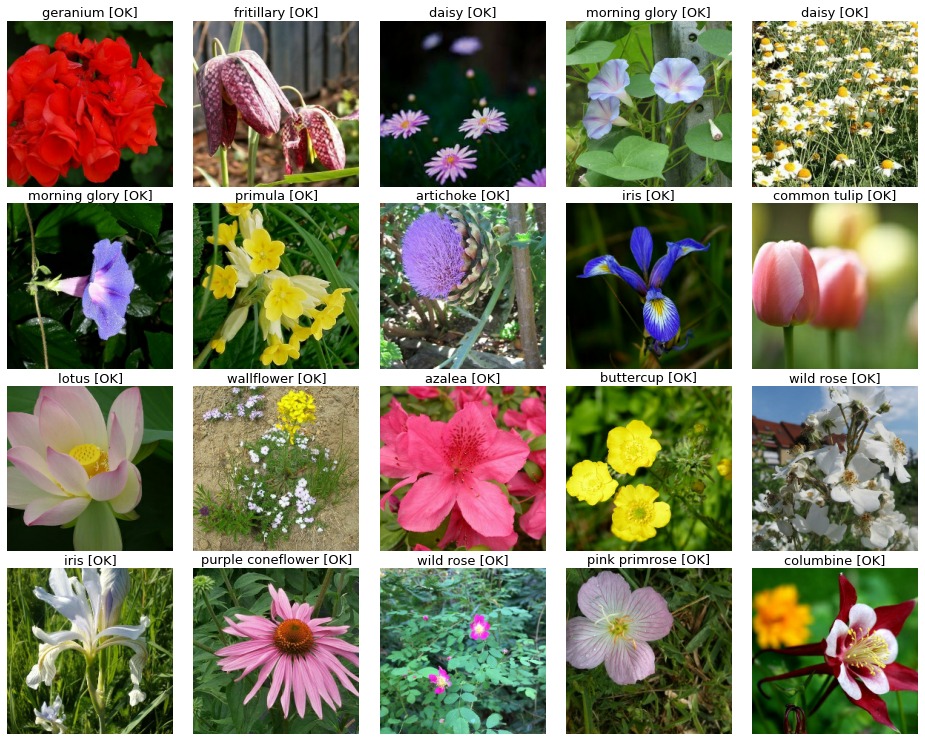

In [47]:
# run this cell again for next set of images
if VALIDATION:
    images, labels = next(batch)
    #probabilities = (model1.predict(images)+model2.predict(images))/2
    #probabilities = model1.predict(images) 
    probabilities = (model1.predict(images)*0.50505)+model2.predict(images)*0.44444+model3.predict(images)*0.05050
    predictions = np.argmax(probabilities, axis=-1)
    display_batch_of_images((images, labels), predictions)